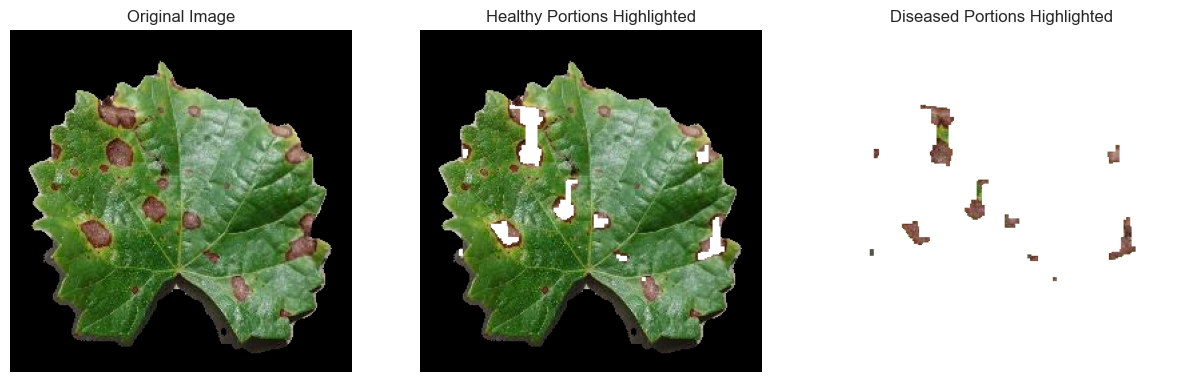

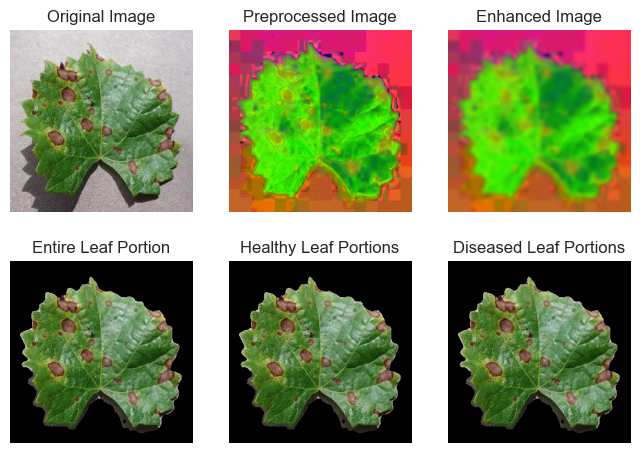

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage import filters
from yellowbrick.cluster import KElbowVisualizer  
import matplotlib.pyplot as plt
def main():
    dataset_path = "Dataset/Task 2-ImageDataset"
    image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.JPG', '.jpeg'))]
    image_paths = "Dataset/Task 2-ImageDataset/fb819384-a48d-4615-becc-7d39d48477e5___FAM_B.Rot 0463.JPG"
    # for image_file in image_files:
    #     image_path = os.path.join(dataset_path, image_file)
    #     image = read_image(image_path)
    #     print(image.shape)        
        # preprocessed_image = preprocess_image(image)
        # enhanced_image = enhance_image(preprocessed_image)
        
        # clustered_image = cluster_image(enhanced_image)
        
        # Further processing, saving, or analysis can be added here
    
    # 1. Read the image    
    original_image = cv2.imread(image_paths)
    # 2. Preprocess the image
    preprocessed_image = preprocess_image(original_image)
    # 3. Enhance image quality
    enhanced_image = enhance_image(preprocessed_image)
    # 4. Cluster the image
    clustered_image = cluster_image(enhanced_image)
    extracted_entire_leaf = extracting_leaf(original_image, clustered_image)
    extracted_diseased_portions = extracting_diseased_portions(extracted_entire_leaf)
    plt.subplot(2, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.title('Preprocessed Image')
    plt.imshow(preprocessed_image)
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title('Enhanced Image')
    plt.imshow(enhanced_image)
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.title('Entire Leaf Portion')
    plt.imshow(extracted_entire_leaf)
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title('Healthy Leaf Portions')
    plt.imshow(extracted_entire_leaf)
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.title('Diseased Leaf Portions')
    plt.imshow(extracted_diseased_portions)
    plt.axis('off')
            
def read_image(image_path):
    original_image = cv2.imread(image_path)
    return original_image

def preprocess_image(image):
    resized_image = cv2.resize(image, (256, 256))
    # convert rgb image to hsv image
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2HSV)
    # extract h s v color elements
    h, s, v = cv2.split(hsv_image)
    
    # distribute the intensity contrast on
    h_equalized = cv2.equalizeHist(h) # hue
    s_equalized = cv2.equalizeHist(s) # saturation
    
    gamma = 5  # Gamma value to incease the lightness/ darkness of colors in image 
    v_corrected = np.clip(255 * (v / 255) ** gamma, 0, 255).astype(np.uint8)
    modified_hsv = cv2.merge([h_equalized, s_equalized, v_corrected])
    
    return modified_hsv
 
def enhance_image(image):
    # Adjusts the contrast & brightness # addWeighted to the whole 3 sp
    # brightness = 1
    # contrast = 1.5
    # contrasted_hsv_image = cv2.addWeighted(image, contrast, np.zeros(image.shape,image.dtype), 0, brightness)

    # Noise removal - image smoothing and blurring
    blurred_hsv_img = cv2.GaussianBlur(image, (15, 15) , 0)
    
    # Sharpen the image
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
    sharpened_hsv_image = cv2.filter2D(blurred_hsv_img, -1, kernel) 
    return sharpened_hsv_image
   
def cluster_image(image):
    Z = image.reshape((-1,3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K=2
    ret, label1, center1 = cv2.kmeans(Z, K, None, criteria, 10,  cv2.KMEANS_RANDOM_CENTERS)
    center1 = np.uint8(center1)
    res1 = center1[label1.flatten()]
    kmean_result = res1.reshape((image.shape))
    return kmean_result

def extracting_leaf(original_image, clustered_image):
    # Convert the clustered image from HSV to GRAY
    rgb_output = cv2.cvtColor(clustered_image, cv2.COLOR_HSV2RGB)
    gray_output = cv2.cvtColor(rgb_output, cv2.COLOR_RGB2GRAY)

    _, binaryImage = cv2.threshold(gray_output, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    binary_mask_3d = cv2.merge([binaryImage, binaryImage, binaryImage])
    extracted_leaf = cv2.bitwise_and(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), binary_mask_3d)
    return extracted_leaf

def extracting_diseased_portions(image):
    # Convert the image from BGR to RGB
    image_rgb = image

    # Convert the RGB image to HSV color space
    hsv_image = image

    # Define the range for the diseased portions (brown spots)
    lower_diseased = np.array([80, 28, 27])   # Lower bound for HSV
    upper_diseased = np.array([157, 111, 108])  # Upper bound for HSV

    # Create a mask for the diseased portions based on the HSV color range
    mask = cv2.inRange(hsv_image, lower_diseased, upper_diseased)

    # Define a kernel for morphological operations
    kernel_open = np.ones((3, 3), np.uint8)
    kernel_close = np.ones((9, 9), np.uint8)
    # # Apply opening to remove noise (small white regions in the black background)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open)

    # # Optionally, apply closing to fill small holes in the detected regions
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel_close)

    # Create an inverted mask to make everything else white
    mask_inverted = cv2.bitwise_not(mask_cleaned)

    # Create a white image
    white_image = np.full_like(image_rgb, 255)

    # Use the mask to combine the original image and the white image
    diseased_only_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_cleaned)
    diseased_result_image = cv2.add(diseased_only_image, cv2.bitwise_and(white_image, white_image, mask=mask_inverted))
    healthy_only_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask_inverted)
    healthy_result_image = cv2.add(healthy_only_image, cv2.bitwise_and(white_image, white_image, mask=mask_cleaned))
    # Display the original, mask, and cleaned mask images
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image_rgb)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Healthy Portions Highlighted")
    plt.imshow(healthy_result_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Diseased Portions Highlighted")
    plt.imshow(diseased_result_image)
    plt.axis('off')

    plt.show()
    return image



if __name__ == "__main__":
    main()
